In [131]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy.io.fits as fits

    
def spatialCoords(l,b,D, origin='galcenter'):
    '''
    converts a set of galactic coordinates to 3-D cartesian
    coordinates centered at the sun or the galactic center.
    
    Parameters:
       origin: 'sun' or 'galcenter'
       l, b: galactic coordinates in degrees
       D: distance from the sun to each object, in parsec
    '''
    cl=np.cos(l*np.pi/180)
    sl=np.sin(l*np.pi/180)
    cb=np.cos(b*np.pi/180)
    sb=np.sin(b*np.pi/180)
    Rsun=8340 #distance from the sun to the GC 
    zsun=27 #the height scale of the sun is set to 27pc according to Chen et al. 2003 
    if origin=='galcenter':
        x=Rsun-D*cl*cb
        z=zsun+D*sb
    else:
        if origin=='galcenterz0':
            x=Rsun-D*cl*cb
            z=0+D*sb
        else:
            x=D*cl*cb
            z=D*sb
    y=-D*sl*cb
    
    return x,y,z

def VrpmUVW(ra, dec, Vr, pmra, pmdec, D, Vrerr, pmraerr, pmdecerr, Derr, velsun):
    '''
    Vpm2UVW converts radial velocities and proper motions to 3D velocities.
    Parameters:
    Vr: radial velocity from observation
    pmra, pmdec: proper motion in equatorial coordinates
    ra,dec:equatorial coordinates
    D: distance to the Sun in pc.
    Return:
    U, V, W: 3D velocity components with respect to LSR
    REF:Johnson & Soderblom(1987)
    '''
    #velsun = [10,5.25,7.17]
    #velsun = [9.58,10.52,7.01]
#    velsun = [9.58,20,7.01]
#    T=[[-0.06699, -0.87276, -0.48354]
#       [+0.49273, -0.45035, +0.74458] 
#       [-0.86760, -0.18837, +0.46020]]
    k = 4.74057 
    ra0 = ra*np.pi/180.0
    dec0 = dec*np.pi/180.0
    cra = np.cos(ra0)
    sra = np.sin(ra0)
    cdec = np.cos(dec0)
    sdec = np.sin(dec0)
    
    
    B11=-0.063491*cra*cdec -0.86554 *sra*cdec -0.496799*sdec
    B12= 0.063491*sra       -0.86554 *cra       +0
    B13= 0.063491*cra*sdec +0.86554 *sra*sdec -0.496799*cdec
    
    B21= 0.493076*cra*cdec -0.460007*sra*cdec +0.738424*sdec
    B22=-0.493076*sra       -0.460007*cra       +0
    B23=-0.493076*cra*sdec +0.460007*sra*sdec +0.738424*cdec
    
    B31=-0.867666*cra*cdec -0.198076*sra*cdec +0.455984*sdec
    B32= 0.867666*sra       -0.198076*cra       +0
    B33= 0.867666*cra*sdec +0.198076*sra*sdec +0.455984*cdec
    
    U = velsun[0]+Vr*B11+k*pmra*D*B12/1000.0+k*pmdec*D*B13/1000.0
    V = velsun[1]+Vr*B21+k*pmra*D*B22/1000.0+k*pmdec*D*B23/1000.0
    W = velsun[2]+Vr*B31+k*pmra*D*B32/1000.0+k*pmdec*D*B33/1000.0
    Uerr = np.sqrt(B11**2*Vrerr**2+\
        (k*B12/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B13/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Verr=np.sqrt(B21**2*Vrerr**2+\
        (k*B22/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B23/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
    Werr=np.sqrt(B31**2*Vrerr**2+\
        (k*B32/1000.0)**2*(D**2*pmraerr**2+pmra**2*Derr**2)+\
        (k*B33/1000.0)**2*(Derr**2*pmdec**2+pmdecerr**2*D**2))
        
    return U,V,W,Uerr,Verr,Werr



def velocitycart2cylindrical(U,V,W,l,b,dist,Uerr,Verr,Werr,disterr,Vlsr,Rsun):
    '''
        Convert the UVW to velocity compoennts in cylindrical coordinates
        Parameters:
        U: velocity in X, in km/s
        V: velocity in Y, in km/s
        W: velocity in Y, in km/s
        l,b: Galactic coordniates, in degrees
        dist: distance in pc
        Vlsr circular speed at LSR
        Rsun: distance from the Galactic center to the Sun;\
    '''

    cbsl=np.cos(np.deg2rad(b))*np.sin(np.deg2rad(l))
    cbcl=np.cos(np.deg2rad(b))*np.cos(np.deg2rad(l))
    tanphi=(dist*cbsl/(Rsun-dist*cbcl))
    tanphierr2=disterr**2*(cbsl**2*Rsun**2)/(Rsun-dist*cbcl)**4
    phi=np.arctan(tanphi)
    phierr2=tanphierr2/(1+tanphi**2)**2
    VR=-np.cos(phi)*U+np.sin(phi)*(V+Vlsr)
    VPhi=np.sin(phi)*U+np.cos(phi)*(V+Vlsr)
    VZ=W
    VRerr=np.sqrt((np.cos(phi)**2)*(Uerr**2)+(np.sin(phi)**2)*(Verr**2)+\
                  ((U*np.sin(phi)+(V+Vlsr)*np.cos(phi))**2)*phierr2)
    VPhierr=np.sqrt((np.sin(phi)**2)*(Uerr**2)+(np.cos(phi)**2)*(Verr**2)+\
                  ((U*np.cos(phi)-(V+Vlsr)*np.sin(phi))**2)*phierr2)
    VZerr=Werr
    phi0=phi
    return VR,VPhi,VZ,VRerr,VPhierr,VZerr,phi0
    
def velocity(tgas0, V0, velsun, Rsun):
    '''
        derive velocities with lamost-tgas catalog
        Parameters:
        tgas0: the lamost-tgas catalog
        V0: the circular speed at LSR
        velsun: the solar motion wrt. the LSR
        Rsun: the distance from the Galactic center to the Sun
    '''
    U, V, W, Uerr, Verr, Werr =\
        VrpmUVW(tgas0.ra_tgas,tgas0.dec_tgas,tgas0.rv+5.7,tgas0.pmra_tgas,tgas0.pmdec_tgas,\
        tgas0.dist_tgas,np.repeat(5.0,len(tgas0.obsid)),\
        tgas0.pmra_error_tgas,tgas0.pmdec_error_tgas,\
        tgas0.dist_tgas*tgas0.dist_error_tgas, velsun)
    VR,VPHI,VZ,VRerr,VPHIerr,VZerr, PHI0 = velocitycart2cylindrical(U,V,W,\
        tgas0.l_tgas,tgas0.b_tgas,\
        tgas0.dist_tgas,Uerr,Verr,Werr,tgas0.dist_tgas*tgas0.dist_error_tgas,\
        V0,Rsun)
    return U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr,VZ,VZerr


def loadData(filename):
    '''
    Read fits data
    '''
    tchfits = fits.open(filename)
    tgas = tchfits[1].data
    return tgas

 
def drawInplaneVelDist(VR,VPHI,FeH):
    '''
    draw distribution of VR vs. VPhi
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.plot(VR,VPHI,'k.',markersize=2)
    sc = ax.scatter(VR, VPHI, c=FeH, alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    ax.set_xlim([-150,150])
    ax.set_ylim([0,300])
    plt.xlabel('VR')
    plt.ylabel('VPhi')
    fig.colorbar(sc)
    fig.show()
    
    
def drawHRdiagram(Teff,MK):
    '''
    draw Teff-MK (HR) diagram
    '''
    Tgrid = np.linspace(3500,9000,num=50)
    Mgrid = np.linspace(-10,10,num=100)
    HRD,xedges,yedges = np.histogram2d(MK,Teff,bins=[Mgrid,Tgrid])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax.imshow(HRD,extent=[yedges[0],yedges[-1],xedges[-1],xedges[0]])
    ax.contour(np.log(HRD+1.),20,extent=[yedges[0],yedges[-1],xedges[0],xedges[-1]])    
    ax.set_aspect('auto')
    ax.set_xlim([8500,3600])
    ax.set_ylim([10,-10])
    plt.xlabel(r'$T_{\rm eff}$')
    plt.ylabel(r'$M_K$')
    fig.show()
    
    
def drawSpatialDist(x,y,z):
    fig = plt.figure(figsize=[16,10])
    ax_xy = fig.add_subplot(2,2,1)
    ax_xy.plot(x/1.0e3,y/1.0e3,'k.',markersize=2)
    plt.xlabel('X (kpc)')
    plt.ylabel('Y (kpc)')
    ax_xy.set_xlim([6.5,10])
    ax_xy.set_ylim([-2,2])
    ####
    ax_yz = fig.add_subplot(2,2,4)
    ax_yz.plot(y/1.0e3,z/1.0e3,'k.',markersize=2)
    plt.xlabel('Y (kpc)')
    plt.ylabel('Z (kpc)')
    ax_yz.set_xlim([-2,2])
    ax_yz.set_ylim([-2,2])
    ####
    ax_xz = fig.add_subplot(2,2,3)
    ax_xz.plot(x/1.0e3,z/1.0e3,'k.',markersize=2)
    plt.xlabel('X (kpc)')
    plt.ylabel('Z (kpc)')
    ax_xz.set_xlim([6.5,10])
    ax_xz.set_ylim([-2,2])

def median2d(X,Y,Z,Xgrid,Ygrid,N):
    mp = np.ndarray([len(Ygrid)-1,len(Xgrid)-1])
    for i in xrange(len(Ygrid)-1):
        for j in xrange(len(Xgrid)-1):
            ind = (X>=Xgrid[j]) * (X<=Xgrid[j+1]) * (Y>=Ygrid[i]) * (Y<=Ygrid[i+1])
            if np.sum(ind)>N:
                mp[i,j] = median(Z[ind])
            else:
                mp[i,j] = np.nan
    return mp


In [202]:
#isochrones
f = fits.open('/Users/chaoliu/pyw/IMF/isochroneMS.fits')
pars_MS = f[1].data
f = fits.open('/Users/chaoliu/pyw/IMF/isochroneSGB.fits')
pars_SGB = f[1].data
f = fits.open('/Users/chaoliu/pyw/IMF/isochroneRGB.fits')
pars_RGB = f[1].data
f = fits.open('/Users/chaoliu/pyw/IMF/isochroneHB.fits')
pars_HB = f[1].data
iso0_age = np.concatenate((pars_MS.age,pars_SGB.age,pars_RGB.age,pars_HB.age))
iso0_logTe = np.concatenate((pars_MS.logTe,pars_SGB.logTe,pars_RGB.logTe,pars_HB.logTe))
iso0_FeH = np.concatenate((pars_MS.FeH,pars_SGB.FeH,pars_RGB.FeH,pars_HB.FeH))
iso0_MK = np.concatenate((pars_MS.MagK,pars_SGB.MagK,pars_RGB.MagK,pars_HB.MagK))  
ind = np.asarray(iso0_age>0.1)
iso_age = iso0_age[ind]
iso_logTe = iso0_logTe[ind]
iso_FeH = iso0_FeH[ind]
iso_MK = iso0_MK[ind]

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in greater_equal


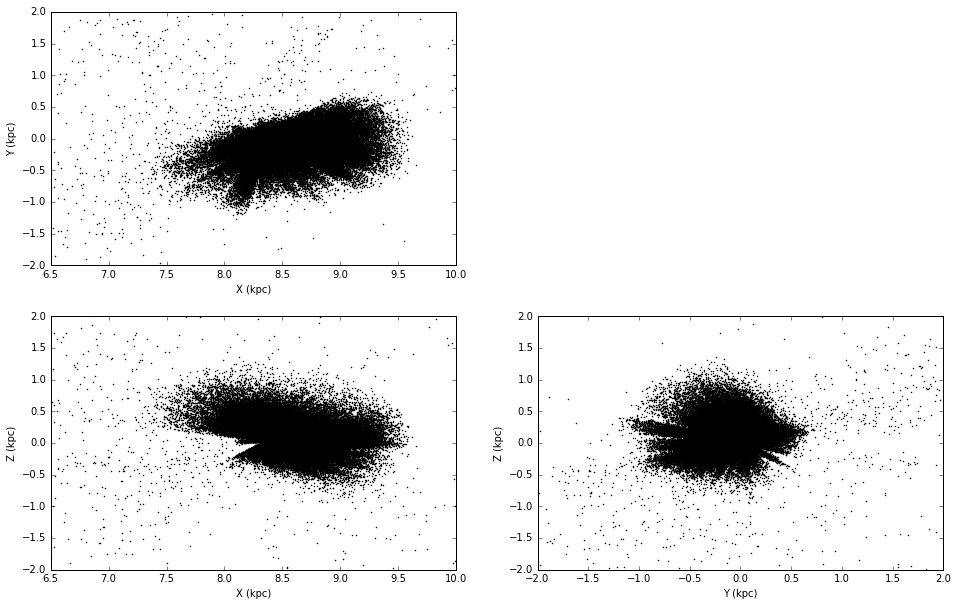

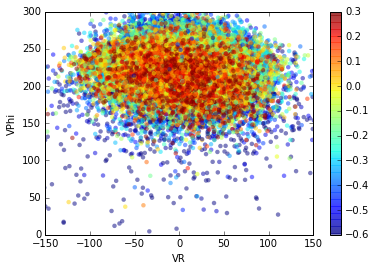

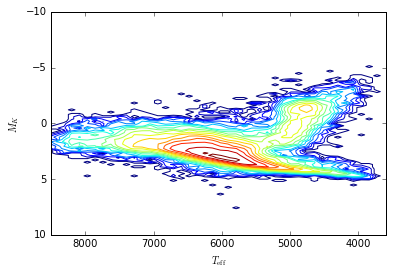

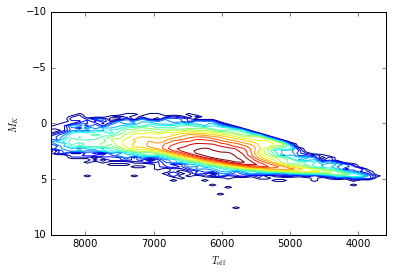

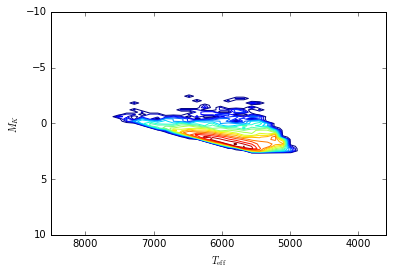

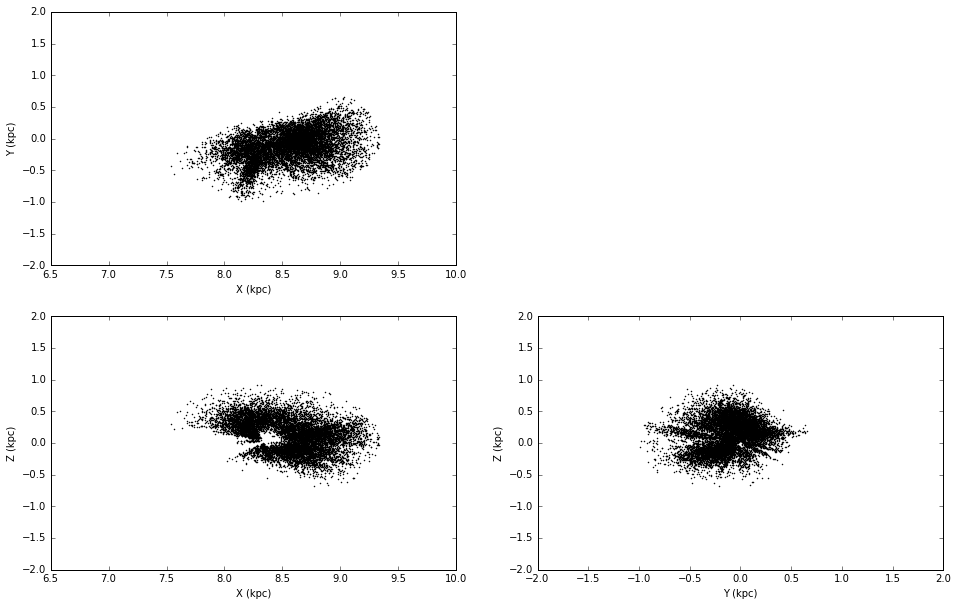

In [132]:
#data file is in dropbox with link: https://www.dropbox.com/s/66uy7ipp0t3gbmp/LAMOST_DR3_TGAS.fits?dl=0
filename = '/Users/chaoliu/mw/lamost_regular/data/DR3/LAMOST_DR3_TGAS_allage.fits'
tgas = loadData(filename)
V0 = 238 #km/s
velsun1 = [9.58,10.52,7.01] #Tian et al. 2015
Rsun = 8340 #Reid 2014 in parsec
X,Y,Z = spatialCoords(tgas.l_tgas,tgas.b_tgas,tgas.dist_tgas)
R = np.sqrt(X**2+Y**2)
Phi = np.arctan(Y/X)
ind = tgas.dist_error_tgas<0.3
drawSpatialDist(X[ind],Y[ind],Z[ind])
U, V, W, Uerr, Verr, Werr,VR,VPHI,VRerr,VPHIerr,VZ,VZerr = velocity(tgas,V0,velsun1,Rsun)
ind = (tgas.dist_error_tgas<0.3) * (np.abs(Z)<300)
drawInplaneVelDist(VR[ind],VPHI[ind],tgas.feh[ind])
drawHRdiagram(tgas.teff[ind],tgas.MK_tgas[ind])
ind_MS = (tgas.dist_error_tgas<0.3) * (tgas.dist_tgas<1000) *\
    (((tgas.teff>3500) * (tgas.teff<6500) * (tgas.MK_tgas>((4.+1.)/(4000.-6500.)*(tgas.teff-6500.)-1.))) +\
    ((tgas.teff<8500) * (tgas.teff>=6500) * (tgas.MK_tgas>-1)))
ind_SGB = (tgas.dist_error_tgas<0.3) * (tgas.MK_tgas<2.5) *(tgas.dist_tgas<1000) *\
    (((tgas.teff>5000) * (tgas.teff<5500) * (tgas.MK_tgas>((2.5+1.)/(5000.-5500.)*(tgas.teff-5500.)-1.))) +\
    ((tgas.teff<=7500) * (tgas.teff>=5500) * (tgas.MK_tgas<((2.5+0.5)/(5500.-7500.)*(tgas.teff-7500.)-0.5))))
    #line1: 5500,2.5;7500,-0.5
    #line2: 5500,-1;5000,2.5
    #line3: 5000-5500,2.5
drawHRdiagram(tgas.teff[ind_MS],tgas.MK_tgas[ind_MS])
drawHRdiagram(tgas.teff[ind_SGB],tgas.MK_tgas[ind_SGB])
drawSpatialDist(X[ind_SGB],Y[ind_SGB],Z[ind_SGB])

In [211]:
#Calculate age
mean_logTe = np.mean(iso_logTe)
std_logTe = np.std(iso_logTe)
mean_MK = np.mean(iso_MK)
std_MK = np.std(iso_MK)
mean_FeH = np.mean(iso_FeH)
std_FeH = np.std(iso_FeH)
stand_iso_logTe = (iso_logTe-mean_logTe)/std_logTe
stand_iso_MK = (iso_MK-mean_MK)/std_MK
stand_iso_FeH = (iso_FeH-mean_FeH)/std_FeH

stand_tgas_logTe = (np.log10(tgas.teff)-mean_logTe)/std_logTe
stand_tgas_MK = (tgas.MK_tgas-mean_MK)/std_MK
stand_tgas_FeH = (tgas.feh-mean_FeH)/std_FeH

age = np.zeros(np.shape(tgas.loga))
for i in xrange(len(tgas.obsid)):
    if tgas.dist_error_tgas[i]<0.3:
        lsq = (stand_tgas_logTe[i]-stand_iso_logTe)**2+\
            (stand_tgas_MK[i]-stand_iso_MK)**2+\
            (stand_tgas_FeH[i]-stand_iso_FeH)**2
        mi = np.argmin(lsq)
        age[i] = iso_age[mi]
    if np.mod(i,10000)==0:
        print i

        

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [210]:
#alternative way w/o standardization
tgas_logTe = np.log10(tgas.teff)
tgas_MK = tgas.MK_tgas
tgas_FeH = tgas.feh
age1 = np.zeros(np.shape(tgas.loga))
for i in xrange(len(tgas.obsid)):
    if tgas.dist_error_tgas[i]<0.3:
        lsq = (tgas_logTe[i]-iso_logTe)**2+\
            (tgas_MK[i]-iso_MK)**2+\
            (tgas_FeH[i]-iso_FeH)**2
        mi = np.argmin(lsq)
        age[i] = iso_age[mi]
    if np.mod(i,10000)==0:
        print i



0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


KeyboardInterrupt: 

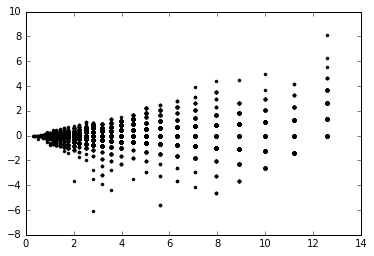

In [212]:
#compare ages from two codes
plt.plot(age[ind_SGB],age[ind_SGB]-10**tgas.loga[ind_SGB]/1e9,'k.')
plt.show()

In [ ]:
#calculate MC error for individual stars

def velocity1(ra_tgas,dec_tgas,l_tgas,b_tgas,rv,pmra_tgas,pmdec_tgas,dist_tgas, V0, velsun, Rsun):
    '''
        derive velocities with lamost-tgas catalog
        Parameters:
        tgas0: the lamost-tgas catalog
        V0: the circular speed at LSR
        velsun: the solar motion wrt. the LSR
        Rsun: the distance from the Galactic center to the Sun
    '''
    U, V, W, Uerr, Verr, Werr =\
        VrpmUVW(ra_tgas,dec_tgas,rv+5.7,pmra_tgas,pmdec_tgas,\
        dist_tgas,np.repeat(0.0,len(rv)),\
        np.repeat(0.0,len(rv)),np.repeat(0.0,len(rv)),\
        np.repeat(0.0,len(rv)), velsun)
    VR,VPHI,VZ,VRerr,VPHIerr,VZerr, PHI0 = velocitycart2cylindrical(U,V,W,\
        l_tgas,b_tgas,\
        dist_tgas,Uerr,Verr,Werr,np.repeat(0.0,len(rv)),\
        V0,Rsun)
    return VR,VPHI,VZ

V0 = 238 #km/s
velsun1 = [9.58,10.52,7.01] #Tian et al. 2015
Rsun = 8340 #Reid 2014 in parsec
M = 100
velerr = np.zeros([len(tgas.l_tgas),6])
for i in xrange(len(tgas.l_tgas)):
    rv = tgas.rv[i]+5.7+sp.random.normal(loc=0,scale=5.0,size=M)
    dist = tgas.dist_tgas[i]+sp.random.normal(loc=0,scale=tgas.dist_error_tgas[i]*\
                                                 tgas.dist_tgas[i],size=M)
    pmra = tgas.pmra_tgas[i]+sp.random.normal(loc=0,scale=tgas.pmra_error_tgas[i],size=M)
    pmde = tgas.pmdec_tgas[i]+sp.random.normal(loc=0,scale=tgas.pmdec_error_tgas[i],size=M)
    VR,VPHI,VZ = velocity1(np.repeat(tgas.ra_tgas[i],M),\
                           np.repeat(tgas.dec_tgas[i],M),\
                           np.repeat(tgas.l_tgas[i],M),\
                           np.repeat(tgas.b_tgas[i],M),\
                           rv,pmra,pmde,dist,V0,velsun1,Rsun)
    meanVR = np.mean(VR)
    meanVPHI = np.mean(VPHI)
    meanVZ = np.mean(VZ)
    sig_RR = np.sum((VR-meanVR)*(VR-meanVR))/M
    sig_RPHI = np.sum((VR-meanVR)*(VPHI-meanVPHI))/M
    sig_RZ = np.sum((VR-meanVR)*(VZ-meanVZ))/M
    sig_PHIPHI = np.sum((VPHI-meanVPHI)*(VPHI-meanVPHI))/M
    sig_PHIZ = np.sum((VZ-meanVZ)*(VPHI-meanVPHI))/M
    sig_ZZ = np.sum((VZ-meanVZ)*(VZ-meanVZ))/M
    velerr[i,:]=[sig_RR,sig_RPHI,sig_RZ,sig_PHIPHI,sig_PHIZ,sig_ZZ]
    if np.mod(i,10000)==0:
        print i
        

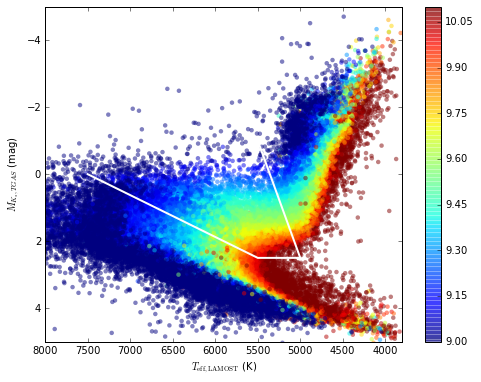

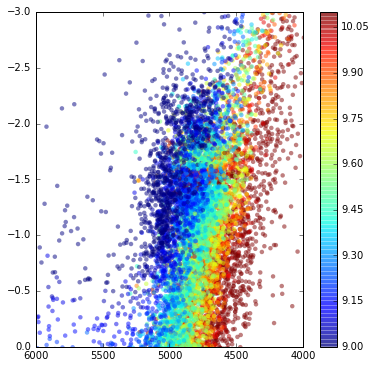

In [262]:
#line1: 5500,2.5;7500,-0.5
#line2: 5500,-1;5000,2.5
#line3: 5000-5500,2.5
ind = (tgas.dist_error_tgas<0.3) * (tgas.snrg>20) * (tgas.snri>20) * (tgas.dist_tgas<1500)
#ind = ind_SGB
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
ssc = ax.scatter(tgas.teff[ind], tgas.MK_tgas[ind], c=np.log10(age[ind]*1e9), \
                 alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
ax.plot([5500,5000,5500,7500],[-1,2.5,2.5,-0.0],'w-',linewidth=2)
ax.set_ylim([5,-5])
ax.set_xlim([8000,3800])
plt.xlabel(r'$T_{\rm eff,LAMOST}$ (K)')
plt.ylabel(r'$M_{K_s,TGAS}$ (mag)')
plt.colorbar(ssc)
fig.show()
fig.savefig('HRD_age_SGB.png',bbox_inches='tight')
###
fig = plt.figure(figsize=[6,6])
ax = fig.add_subplot(111)
ssc = ax.scatter(tgas.teff[ind], tgas.MK_tgas[ind], c=np.log10(age[ind]*1e9), \
                 alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
ax.set_ylim([0,-3])
ax.set_xlim([6000,4000])
plt.colorbar(ssc)
fig.show()

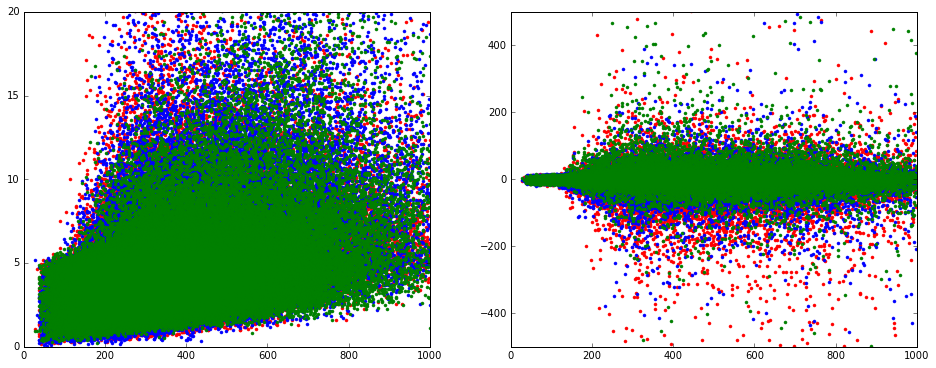

In [42]:
fig = plt.figure(figsize=[16,6])
ax = fig.add_subplot(121)
ax.plot(tgas.dist_tgas[ind_MS],np.sqrt(velerr[ind_MS,0]),'r.')
ax.plot(tgas.dist_tgas[ind_MS],np.sqrt(velerr[ind_MS,3]),'b.')
ax.plot(tgas.dist_tgas[ind_MS],np.sqrt(velerr[ind_MS,5]),'g.')
ax.set_ylim([0,20])

ax = fig.add_subplot(122)
ax.plot(tgas.dist_tgas[ind_MS],velerr[ind_MS,1],'r.')
ax.plot(tgas.dist_tgas[ind_MS],velerr[ind_MS,2],'b.')
ax.plot(tgas.dist_tgas[ind_MS],velerr[ind_MS,4],'g.')
ax.set_ylim([-500,500])

fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal


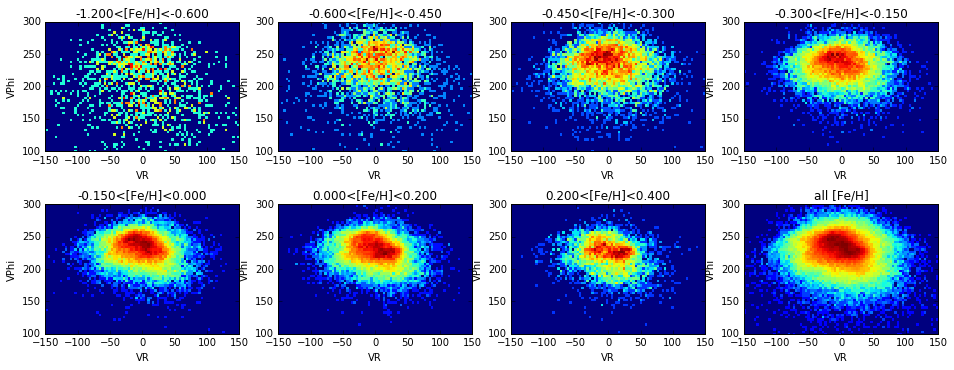

In [46]:
ind0 = ind_MS
fehgrid = np.array([-1.2,-0.6,-0.45,-0.3,-0.15,0,0.2,0.4])
fehcenter = (fehgrid[0:len(fehgrid)-1]+fehgrid[1:len(fehgrid)])/2.0
VRgrid = np.linspace(-150,150,81)
VPhigrid = np.linspace(0,300,81)
fig = plt.figure(figsize=[16,6])
for i in xrange(len(fehcenter)):
    ind = ind0 * (tgas.feh>=fehgrid[i]) * (tgas.feh<=fehgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    #sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    #ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
    mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
    ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
    #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
    ax.set_xlim([-150,150])
    ax.set_ylim([100,300])
    plt.title('%(a).3f<[Fe/H]<%(b).3f' % {'a':fehgrid[i],'b':fehgrid[i+1]})
    plt.xlabel('VR')
    plt.ylabel('VPhi')
ax = fig.add_subplot(2,4,8)
#sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
#ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], VPHI[ind0],bins=[VRgrid,VPhigrid])
ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
#ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.title('all [Fe/H]')
plt.xlabel('VR')
plt.ylabel('VPhi')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal


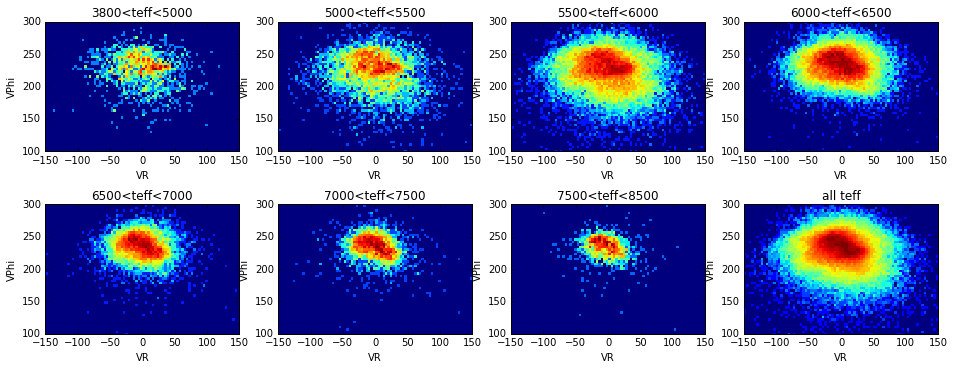

In [47]:
ind0 = ind_MS
teffgrid = np.array([3800,5000,5500,6000,6500,7000,7500,8500])
teffcenter = (teffgrid[0:len(teffgrid)-1]+teffgrid[1:len(teffgrid)])/2.0
VRgrid = np.linspace(-150,150,81)
VPhigrid = np.linspace(0,300,81)
fig = plt.figure(figsize=[16,6])
for i in xrange(len(teffcenter)):
    ind = ind0 * (tgas.teff>=teffgrid[i]) * (tgas.teff<=teffgrid[i+1])
    ax = fig.add_subplot(2,4,i+1)
    #sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
    #ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
    mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
    ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
    #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
    ax.set_xlim([-150,150])
    ax.set_ylim([100,300])
    plt.title('%(a).0f<teff<%(b).0f' % {'a':teffgrid[i],'b':teffgrid[i+1]})
    plt.xlabel('VR')
    plt.ylabel('VPhi')
ax = fig.add_subplot(2,4,8)
#sc = ax.scatter(VR[ind], VPHI[ind], c=tgas.feh[ind], alpha=0.5, vmin=-0.6, vmax=+0.3, edgecolors='none')
#ax.plot(VR[ind], VPHI[ind],'k.',markersize=2)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], VPHI[ind0],bins=[VRgrid,VPhigrid])
ax.imshow(np.log(1.0+mp.T),interpolation='none',extent=[-150,150,300,0])
#ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.title('all teff')
plt.xlabel('VR')
plt.ylabel('VPhi')
fig.show()

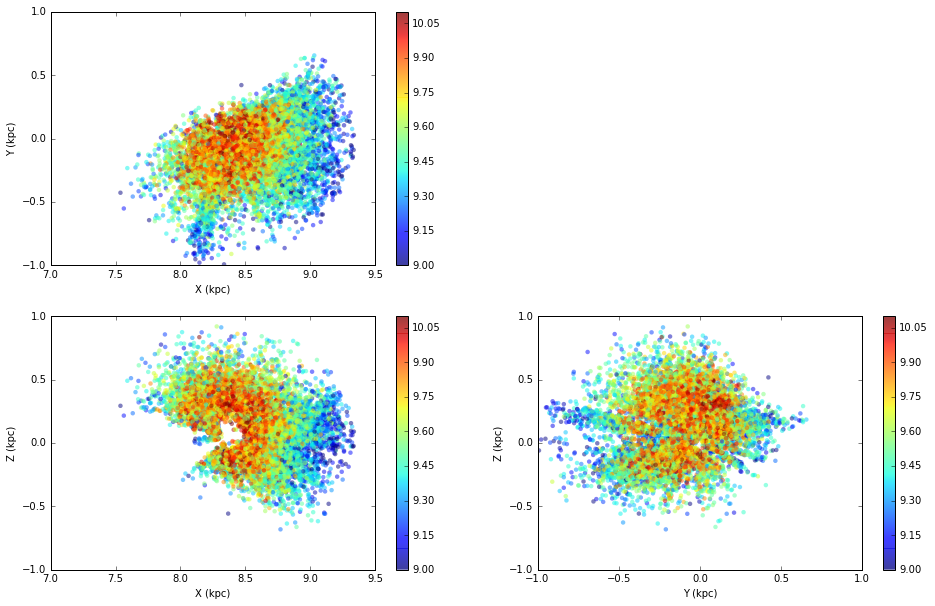

In [215]:
ind0 = ind_SGB# * (tgas.loga>9.3)
x = X[ind0]
y = Y[ind0]
z = Z[ind0]

fig = plt.figure(figsize=[16,10])
ax_xy = fig.add_subplot(2,2,1)
#ax_xy.plot(x/1.0e3,y/1.0e3,'k.',markersize=2)
scxy = ax_xy.scatter(x/1.0e3,y/1.0e3,c=np.log10(age[ind0]*1e9),alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
plt.colorbar(scxy)
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
ax_xy.set_xlim([7,9.5])
ax_xy.set_ylim([-1,1])
####
ax_yz = fig.add_subplot(2,2,4)
#ax_yz.plot(y/1.0e3,z/1.0e3,'k.',markersize=2)
scyz = ax_yz.scatter(y/1.0e3,z/1.0e3,c=np.log10(age[ind0]*1e9),alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
plt.colorbar(scyz)
plt.xlabel('Y (kpc)')
plt.ylabel('Z (kpc)')
ax_yz.set_xlim([-1,1])
ax_yz.set_ylim([-1,1])
####
ax_xz = fig.add_subplot(2,2,3)
#ax_xz.plot(x/1.0e3,z/1.0e3,'k.',markersize=2)
scxz = ax_xz.scatter(x/1.0e3,z/1.0e3,c=np.log10(age[ind0]*1e9),alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
plt.colorbar(scxz)
plt.xlabel('X (kpc)')
plt.ylabel('Z (kpc)')
ax_xz.set_xlim([7,9.5])
ax_xz.set_ylim([-1,1])

fig.show()
fig.savefig('XYZ_SGB_age.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


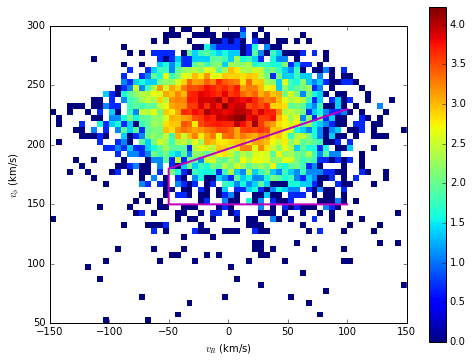

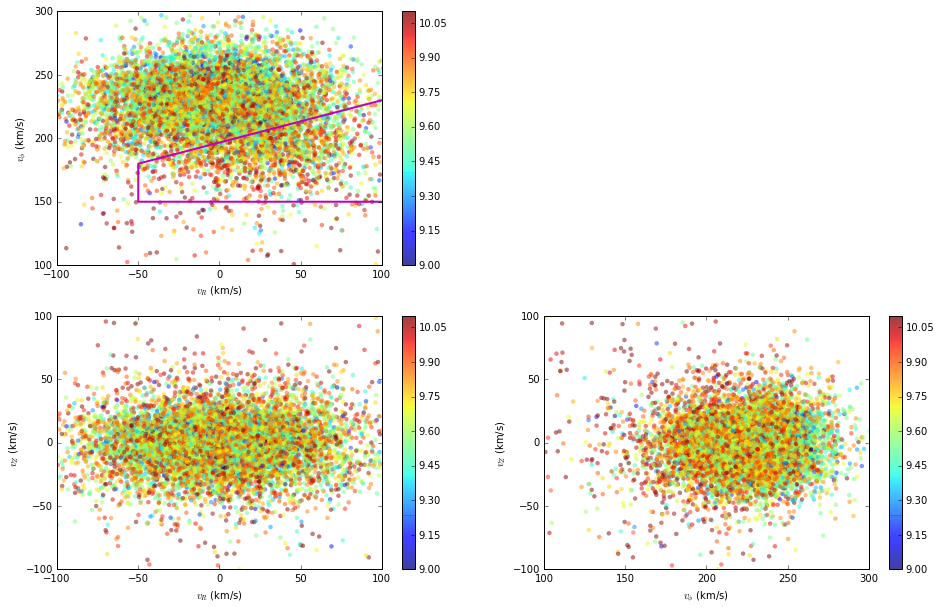

In [264]:
#overall velocity distribution
ind0 = ind_SGB# * (tgas.loga>9.3)
x = VR[ind0]
y = VPHI[ind0]
z = VZ[ind0]
VRgrid = np.linspace(-150,150,61)
VPhigrid = np.linspace(0,300,61)


###
fig = plt.figure(figsize=[8,6])
ax_xy = fig.add_subplot(111)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], VPHI[ind0],bins=[VRgrid,VPhigrid])
scxy = ax_xy.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,300,0])
ax_xy.plot([100,-50,-50,100],[150,150,180,230],'m-',linewidth=2)
plt.colorbar(scxy)
plt.xlabel(r'$v_R$ (km/s)')
plt.ylabel(r'$v_\phi$ (km/s)')
ax_xy.set_xlim([-150,150])
ax_xy.set_ylim([50,300])
fig.show()
fig.savefig('VRVPhi_SGB.png',bbox_inches='tight')
###
fig = plt.figure(figsize=[16,10])
ax_xy = fig.add_subplot(2,2,1)
#ax_xy.plot(x/1.0e3,y/1.0e3,'k.',markersize=2)
scxy = ax_xy.scatter(x,y,c=np.log10(age[ind0]*1e9),alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
ax_xy.plot([100,-50,-50,100],[150,150,180,230],'m-',linewidth=2)
plt.colorbar(scxy)
plt.xlabel(r'$v_R$ (km/s)')
plt.ylabel(r'$v_\phi$ (km/s)')
ax_xy.set_xlim([-100,100])
ax_xy.set_ylim([100,300])
####
ax_yz = fig.add_subplot(2,2,4)
#ax_yz.plot(y/1.0e3,z/1.0e3,'k.',markersize=2)
scyz = ax_yz.scatter(y,z,c=np.log10(age[ind0]*1e9),alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
plt.colorbar(scyz)
plt.xlabel(r'$v_\phi$ (km/s)')
plt.ylabel(r'$v_Z$ (km/s)')
ax_yz.set_xlim([100,300])
ax_yz.set_ylim([-100,100])
####
ax_xz = fig.add_subplot(2,2,3)
#ax_xz.plot(x/1.0e3,z/1.0e3,'k.',markersize=2)
scxz = ax_xz.scatter(x,z,c=np.log10(age[ind0]*1e9),alpha=0.5, vmin=9, vmax=10.1, edgecolors='none')
plt.colorbar(scxz)
plt.xlabel(r'$v_R$ (km/s)')
plt.ylabel(r'$v_Z$ (km/s)')
ax_xz.set_xlim([-100,100])
ax_xz.set_ylim([-100,100])

fig.show()
fig.savefig('Vel_SGB_age.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in log


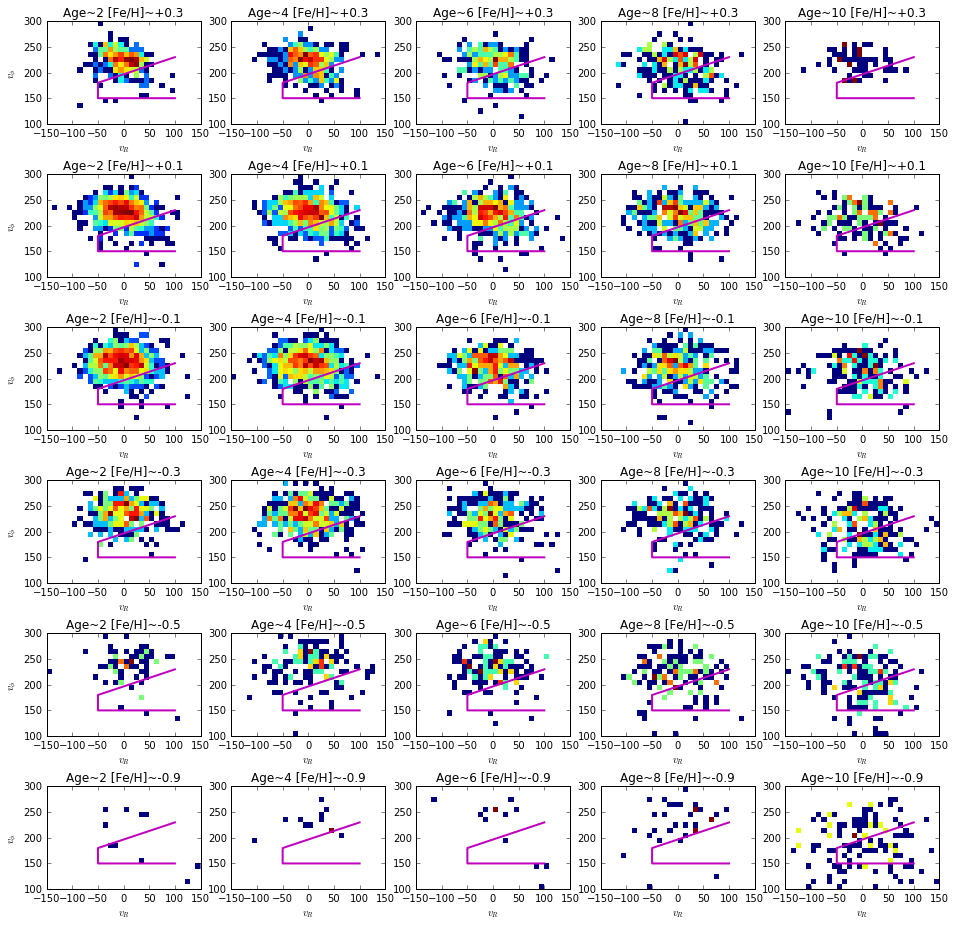

In [280]:
ind0 = ind_SGB
teffgrid = np.array([3800,5000,5500,6000,6500,7000,7500,8500])
teffcenter = (teffgrid[0:len(teffgrid)-1]+teffgrid[1:len(teffgrid)])/2.0
#Agegrid = np.array([0,np.log10(1e9),np.log10(2e9),np.log10(3e9),\
#                    np.log10(4e9),np.log10(5e9),np.log10(6e9),np.log10(7e9),\
#                   np.log10(8e9),np.log10(14e9)])

#Agegrid = np.array([np.log10(1e8),np.log10(3e9),np.log10(5e9),np.log10(7e9),\
#                   np.log10(9e9),np.log10(14e9)])
Agegrid = np.array([0.1,3,5,7,9,15])
Agecenter = [2,4,6,8,10]
#MKgrid = np.array([-10,1.07,1.6,1.85,2.0,2.5])#feh=0
#MKcenter = (MKgrid[0:len(MKgrid)-1]+MKgrid[1:len(MKgrid)])/2.0
fehgrid = np.array([-1.2,-0.6,-0.4,-0.2,-0.0,0.2,0.4])
fehcenter = (fehgrid[0:len(fehgrid)-1]+fehgrid[1:len(fehgrid)])/2.0
#MKmesh = np.zeros([len(teffcenter),len(fehcenter)])
VRgrid = np.linspace(-150,150,31)
VPhigrid = np.linspace(0,300,31)
VZgrid = np.linspace(-150,150,31)
fig = plt.figure(figsize=[16,16])
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(Agecenter),(i)+(len(fehcenter)-1-j)*len(Agecenter)+1)
        mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
        ax.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,300,0])
        ax.plot([100,-50,-50,100],[150,150,180,230],'m-',linewidth=2)
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([100,300])
        #if j==(len(fehcenter)-1) and i!=0:
        #    plt.title('Age~%(b)s' % {'b':Agecenter[i]})
        #if i==0 and j!=(len(fehcenter)-1):
        #    plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        #if i==0 and j==(len(fehcenter)-1):
        plt.title('Age~%(b)s [Fe/H]~%(c)+.1f' % {'b':Agecenter[i],'c':fehcenter[j]})
        plt.xlabel(r'$v_R$')
        if i==0:
            plt.ylabel(r'$v_\phi$')
fig.show()
fig.savefig('VRVPhi_AgeFeH.png',bbox_inches='tight')

###
#fig = plt.figure(figsize=[6,6])
#ax = fig.add_subplot(111)
#im = ax.imshow(MKmesh.T,extent=[teffcenter[0],teffcenter[-1],fehcenter[-1],fehcenter[0]],interpolation='none',aspect='auto')
#plt.colorbar(im)
#fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


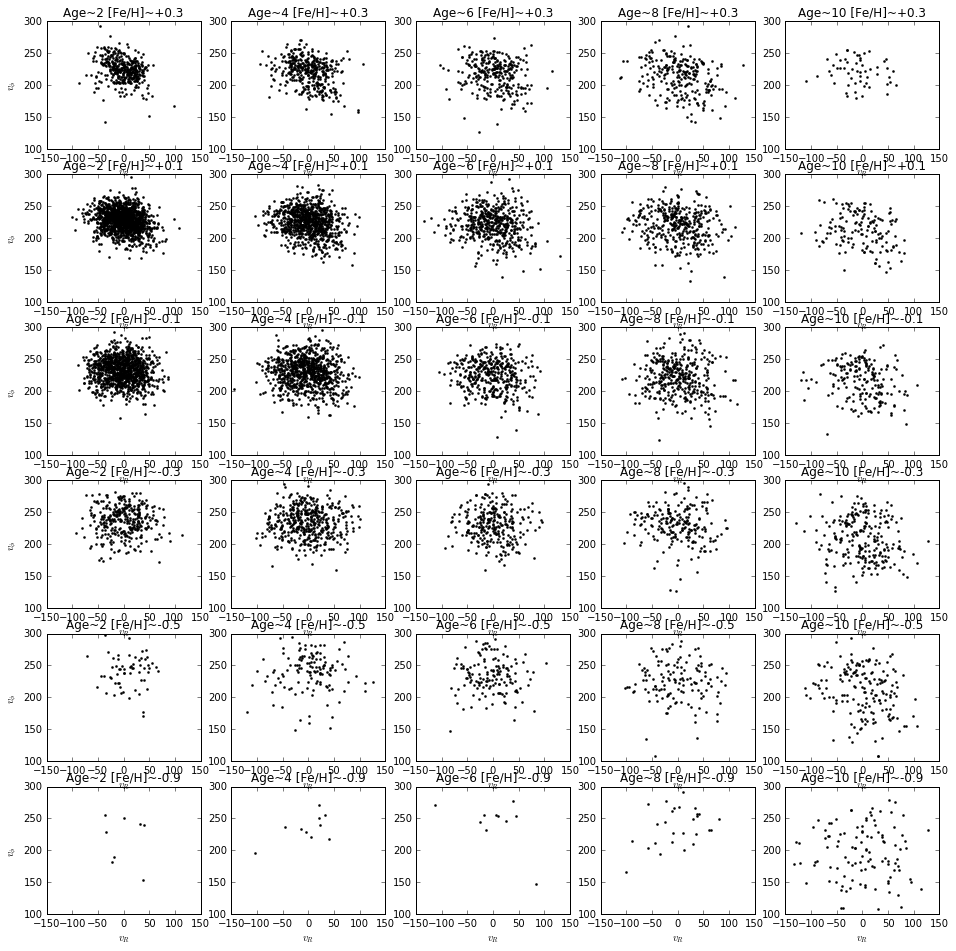

In [307]:
fig = plt.figure(figsize=[16,16])
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(Agecenter),(i)+(len(fehcenter)-1-j)*len(Agecenter)+1)
        #mp,xgrid,ygrid = np.histogram2d(VR[ind], VPHI[ind],bins=[VRgrid,VPhigrid])
        #ax.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,300,0])
        ax.plot(VR[ind], VPHI[ind],'.k',markersize=4)
        #ax.plot([100,-50,-50,100],[150,150,180,230],'m-',linewidth=2)
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([100,300])
        #if j==(len(fehcenter)-1) and i!=0:
        #    plt.title('Age~%(b)s' % {'b':Agecenter[i]})
        #if i==0 and j!=(len(fehcenter)-1):
        #    plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        #if i==0 and j==(len(fehcenter)-1):
        plt.title('Age~%(b)s [Fe/H]~%(c)+.1f' % {'b':Agecenter[i],'c':fehcenter[j]})
        plt.xlabel(r'$v_R$')
        if i==0:
            plt.ylabel(r'$v_\phi$')
fig.show()

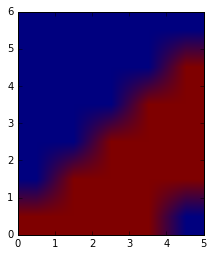

In [329]:
mark_map=np.array([[0,0,0,0,0,1],[0,0,0,0,1,1],[0,0,0,1,1,1],[0,0,1,1,1,1],[0,1,1,1,1,0]])
plt.imshow(mark_map.T,extent=[0,5,0,6])
plt.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal


4977 5501


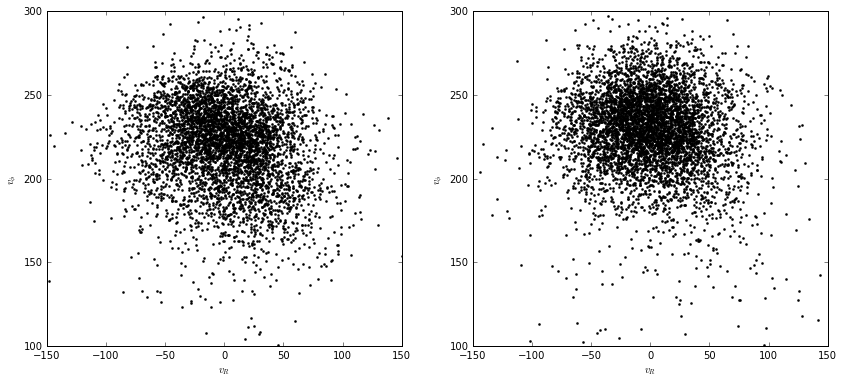

In [331]:
ind0 = np.zeros(np.shape(ind_SGB))
ind1 = np.zeros(np.shape(ind_SGB))
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        if mark_map[i,j]>0.5:
            ind0 = ind0+((age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
                (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1]))
        if mark_map[i,j]<0.5:
            ind1 = ind1 + ((age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
                (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1]))
ind0 = (ind0>0) * ind_SGB
ind1 = (ind1>0) * ind_SGB
###########################
fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(121)
ax.plot(VR[ind0],VPHI[ind0],'k.',markersize=4)
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.xlabel(r'$v_R$')
plt.ylabel(r'$v_\phi$')                    
ax = fig.add_subplot(122)
ax.plot(VR[ind1],VPHI[ind1],'k.',markersize=4)
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.xlabel(r'$v_R$')
plt.ylabel(r'$v_\phi$') 
fig.show()
print sum(ind0),sum(ind1)

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log


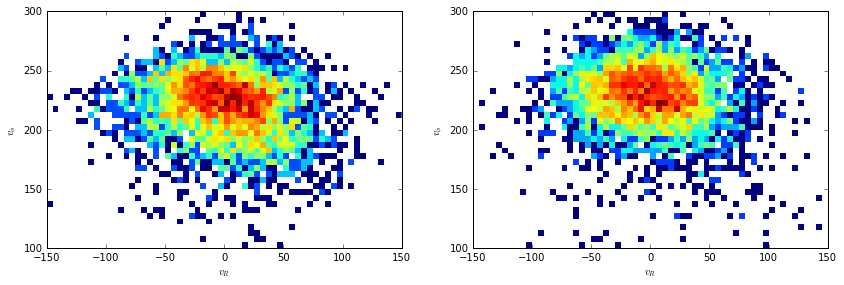

In [344]:
VRgrid = np.linspace(-150,150,61)
VPhigrid = np.linspace(0,300,61)
fig = plt.figure(figsize=[14,6])
ax = fig.add_subplot(121)
mp,xgrid,ygrid = np.histogram2d(VR[ind0], VPHI[ind0],bins=[VRgrid,VPhigrid])
ax.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,300,0])
#ax.plot([100,-50,-50,100],[150,150,180,230],'m-',linewidth=2)
#ax.contour(np.log(mp.T),20,interpolation='none',extent=[-150,150,0,300])
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.xlabel(r'$v_R$')
plt.ylabel(r'$v_\phi$')
######################################
ax = fig.add_subplot(122)
mp,xgrid,ygrid = np.histogram2d(VR[ind1], VPHI[ind1],bins=[VRgrid,VPhigrid])
ax.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,300,0])
#ax.plot([100,-50,-50,100],[150,150,180,230],'m-',linewidth=2)
#ax.contour(np.log(mp.T),20,interpolation='cubic',extent=[-150,150,0,300])
ax.set_xlim([-150,150])
ax.set_ylim([100,300])
plt.xlabel(r'$v_R$')
plt.ylabel(r'$v_\phi$')
fig.show()

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


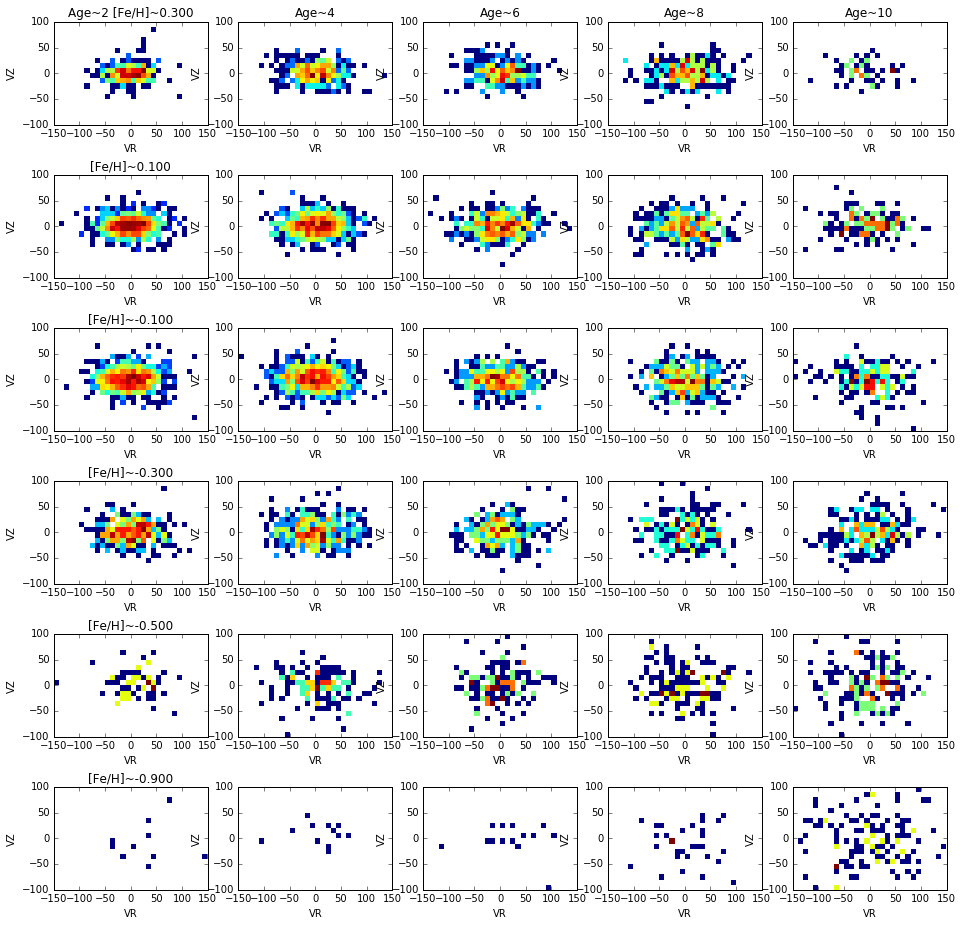

In [222]:
################
fig = plt.figure(figsize=[16,16])
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(Agecenter),(i)+(len(fehcenter)-1-j)*len(Agecenter)+1)
        mp,xgrid,ygrid = np.histogram2d(VR[ind], VZ[ind],bins=[VRgrid,VZgrid])
        ax.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,-150,150])
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([-100,100])
        if j==(len(fehcenter)-1) and i!=0:
            plt.title('Age~%(b)s' % {'b':Agecenter[i]})
        if i==0 and j!=(len(fehcenter)-1):
            plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        if i==0 and j==(len(fehcenter)-1):
            plt.title('Age~%(b)s [Fe/H]~%(c).3f' % {'b':Agecenter[i],'c':fehcenter[j]})
        plt.xlabel('VR')
        plt.ylabel('VZ')
fig.show()
fig.savefig('VRVZ_AgeFeH.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


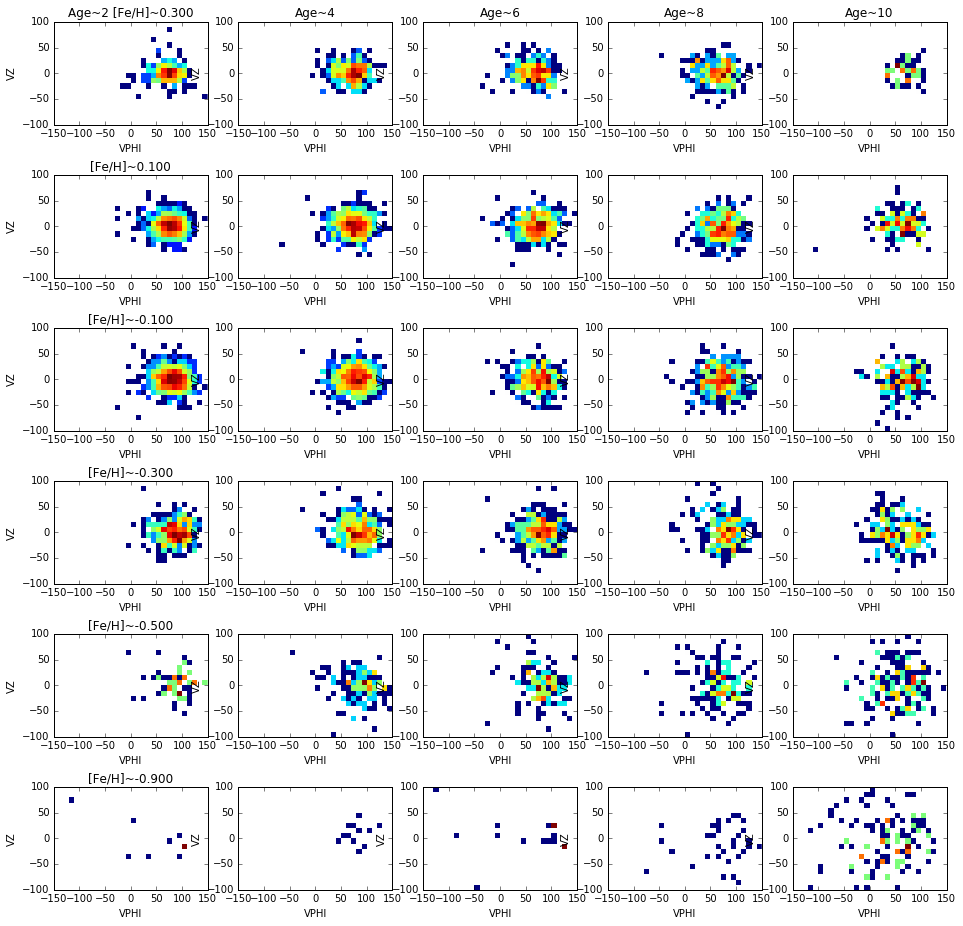

In [223]:
################
fig = plt.figure(figsize=[16,16])
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        #if np.sum(ind)>2:
        #    MKmesh[i,j]=np.median(tgas.MK_tgas[ind])
        #print (i)+(6-j)*5+1
        ax = fig.add_subplot(len(fehcenter),len(Agecenter),(i)+(len(fehcenter)-1-j)*len(Agecenter)+1)
        mp,xgrid,ygrid = np.histogram2d(VPHI[ind], VZ[ind],bins=[VPhigrid,VZgrid])
        ax.imshow(np.log(mp.T),interpolation='none',extent=[-150,150,-150,150])
        #ax.contourf(np.log(1.+mp.T),20,interpolation='none',extent=[-150,150,0,300])
        ax.set_xlim([-150,150])
        ax.set_ylim([-100,100])
        if j==(len(fehcenter)-1) and i!=0:
            plt.title('Age~%(b)s' % {'b':Agecenter[i]})
        if i==0 and j!=(len(fehcenter)-1):
            plt.title('[Fe/H]~%(c).3f' % {'c':fehcenter[j]})
        if i==0 and j==(len(fehcenter)-1):
            plt.title('Age~%(b)s [Fe/H]~%(c).3f' % {'b':Agecenter[i],'c':fehcenter[j]})
        plt.xlabel('VPHI')
        plt.ylabel('VZ')
fig.show()
fig.savefig('VPHIVZ_AgeFeH.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:58: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:83: Runti

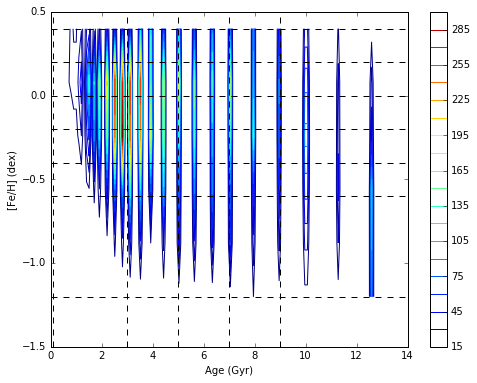

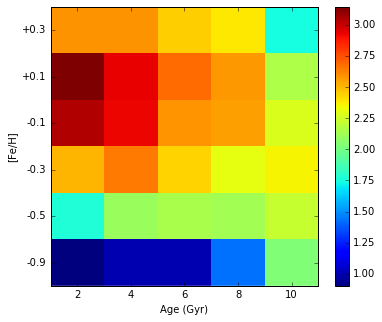

In [289]:
#calculate velocity ellipsoid
def bootstrap(func, x, N, alpha=0.15):
    '''
    Run a boots
    
    Parameters:
    func: function using x as arguement
    x: data
    N: number of repeat
    alpha: percentile
    '''
    nx = len(x)
    xb = np.random.choice(x, (nx,N), replace=True)
    #print np.shape(xb)
    yb = func(xb,axis=0)
    lower = np.percentile(yb, alpha*100)
    upper = np.percentile(yb, (1.-alpha)*100)
    return lower, upper

def bootstrap2(func, x,y, N, alpha=0.15):
    '''
    Run a boots
    
    Parameters:
    func: function using x as arguement
    x: data
    N: number of repeat
    alpha: percentile
    '''
    nx = len(x)
    xb = np.random.choice(x, (nx,N), replace=True)
    yb = np.random.choice(y, (nx,N), replace=True)
    #print (xb)
    #print yb
    zb = np.zeros([N,1])
    for i in xrange(N):
        zb [i] = func(xb[:,i],yb[:,i])
    #print zb
    lower = np.percentile(zb, alpha*100)
    upper = np.percentile(zb, (1.-alpha)*100)
    return lower, upper


def sigmaxy(x,y):
    return np.sum((x-np.mean(x))*(y-np.mean(y)))/len(x)


def sigmaxx(x,axis=0):
    return np.sum((x-np.mean(x))**2)/len(x)

def alpha(x,y):
    s_x=sigmaxx(x)
    s_y=sigmaxx(y)
    s_xy=sigmaxy(x,y)
    return 0.5*np.arctan((2*s_xy)/(s_x-s_y))
    
ind_Her = (VR>-50) * (VPHI<((180.-230.)/(-50.-100.)*(VR-100.)+230.)) * (VPHI>150) * ind_SGB
ind_Main = ((VR<=-50) + (VPHI>=((180.-230.)/(-50.-100.)*(VR-100.)+230.)) + (VPHI<150)) * ind_SGB


#Agegrid = np.array([np.log10(1e8),np.log10(2e9),np.log10(3e9),\
#                    np.log10(4e9),np.log10(5e9),np.log10(6e9),np.log10(7e9),\
#                   np.log10(8e9),np.log10(9e9),np.log10(15e9)])
#Agecenter =np.array([1,2.5,3.5,4.5,5.5,6.5,7.5,8.5,10])
ind0 = ind_SGB * (velerr[:,0]<225) * (velerr[:,3]<225) * (velerr[:,5]<225) *\
    (np.abs(VR)<150) * (np.abs(VPHI-238)<300) * (np.abs(VZ)<150) * (VPHI>100)
meanVR = np.zeros([len(Agecenter),len(fehcenter)])
meanVPHI = np.zeros([len(Agecenter),len(fehcenter)])
meanVZ = np.zeros([len(Agecenter),len(fehcenter)])
sig_RR = np.zeros([len(Agecenter),len(fehcenter)])
sig_RPHI = np.zeros([len(Agecenter),len(fehcenter)])
sig_RZ = np.zeros([len(Agecenter),len(fehcenter)])
sig_PHIPHI = np.zeros([len(Agecenter),len(fehcenter)])
sig_PHIZ = np.zeros([len(Agecenter),len(fehcenter)])
sig_ZZ = np.zeros([len(Agecenter),len(fehcenter)])



Nmap = np.zeros([len(Agecenter),len(fehcenter)])
Nhermap = np.zeros([len(Agecenter),len(fehcenter)])
mask_map = np.zeros([len(Agecenter),len(fehcenter)])
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        Nmap[i,j] = np.sum(ind)
        Nhermap[i,j] = np.sum(ind * ind_Her)
        #print np.sum(ind)
        if np.sum(ind)>20:
            mask_map[i,j] = 1
            meanVR[i,j] = np.mean(VR[ind])
            meanVPHI[i,j] = np.mean(VPHI[ind])
            meanVZ[i,j] = np.mean(VZ[ind])
            sig_RR[i,j] = np.sum((VR[ind]-meanVR[i,j])**2)/np.sum(ind)-np.mean(velerr[ind,0])
            sig_RPHI[i,j] = np.sum((VR[ind]-meanVR[i,j])*(VPHI[ind]-meanVPHI[i,j]))/np.sum(ind)-np.mean(velerr[ind,1])
            sig_RZ[i,j] = np.sum((VR[ind]-meanVR[i,j])*(VZ[ind]-meanVZ[i,j]))/np.sum(ind)-np.mean(velerr[ind,2])
            sig_PHIPHI[i,j] = np.sum((VPHI[ind]-meanVPHI[i,j])**2)/np.sum(ind)-\
                np.mean(velerr[ind,3])
            sig_PHIZ[i,j] = np.sum((VPHI[ind]-meanVPHI[i,j])*(VZ[ind]-meanVZ[i,j]))/np.sum(ind)-np.mean(velerr[ind,4])
            sig_ZZ[i,j] = np.sum((VZ[ind]-meanVZ[i,j])**2)/np.sum(ind)-np.mean(velerr[ind,5])
            
        else:
            mask_map[i,j]=np.NAN    

#lv = 0.5*np.arctan(2*sig_RPHI/(sig_RR-sig_PHIPHI))*180.0/np.pi
vv=sig_RR-sig_PHIPHI
u = 2*sig_RPHI/(vv)
lv = 0.5*np.arctan(u)*180.0/np.pi

vv=sig_PHIPHI-sig_ZZ
u = 2*sig_PHIZ/(vv)
Alpha_PHIZ = 0.5*np.arctan(u)*180.0/np.pi

vv=sig_RR-sig_ZZ
u = 2*sig_RZ/(vv)
Alpha_RZ = 0.5*np.arctan(u)*180.0/np.pi

sig_RR = np.sqrt(sig_RR)
sig_RPHI = np.sign(sig_RPHI)*np.sqrt(np.abs(sig_RPHI))
sig_RZ = np.sign(sig_RZ)*np.sqrt(np.abs(sig_RZ))
sig_PHIPHI = np.sqrt(sig_PHIPHI)
sig_PHIZ = np.sign(sig_PHIZ)*np.sqrt(np.abs(sig_PHIZ))
sig_ZZ = np.sqrt(sig_ZZ)



tlabs = [r'$\langle V_R\rangle$',r'$\langle V_\phi\rangle$',r'$\langle V_Z\rangle$',\
         r'$\sigma_R$',r'$\sigma_\phi$',r'$\sigma_Z$',\
         r'$\sigma_{R\phi}$',r'$\sigma_{RZ}$',r'$\sigma_{\phi Z}$']
sig = [meanVR,meanVPHI,meanVZ,sig_RR,sig_PHIPHI,sig_ZZ,sig_RPHI,sig_RZ,sig_PHIZ]
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
AgegridHi = np.linspace(0,15,151)
AgecenterHi = (AgegridHi[0:len(AgegridHi)-1]+AgegridHi[1:len(AgegridHi)])/2.0
NmapHi = np.zeros([len(AgecenterHi),len(fehcenter)])
for i in xrange(len(AgecenterHi)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=AgegridHi[i]) * (age<=AgegridHi[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        NmapHi[i,j] = np.sum(ind)
ct = ax.contour(NmapHi.T,20,extent=[AgegridHi[0],AgegridHi[-1],fehgrid[0],fehgrid[-1]])
for i in xrange(len(fehgrid)):
    ax.plot([0.,15.],[fehgrid[i],fehgrid[i]],'k--')
for i in xrange(len(Agegrid)):
    ax.plot([Agegrid[i],Agegrid[i]],[-1.5,+0.5],'k--')
#ax.plot(age[ind_SGB],tgas.feh[ind_SGB],'k.',markersize=2)
plt.colorbar(ct)
ax.set_ylim([fehcenter[0],fehcenter[-1]])
ax.set_xlim([0,14])
ax.set_ylim([-1.5,0.5])
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H] (dex)')
fig.show()
fig.savefig('AMR.png',bbox_inches='tight')

######
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(np.log10(Nmap.T),extent=[0,10,12,0],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Nstars_AM.png',bbox_inches='tight')



In [282]:
print np.sum(ind_SGB)
print np.sum(ind_Her)
print np.sum(ind_Main)

print float(np.sum(ind_Her))/float(np.sum(ind_Main))


10633
1633
9000
0.181444444444


/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in divide


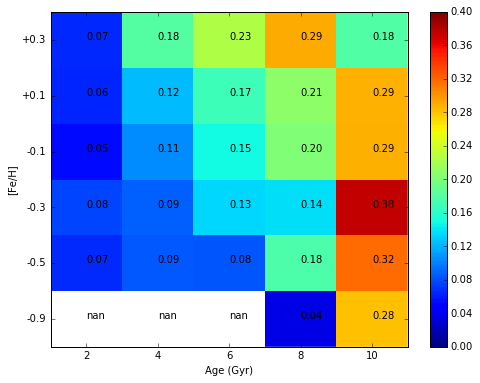

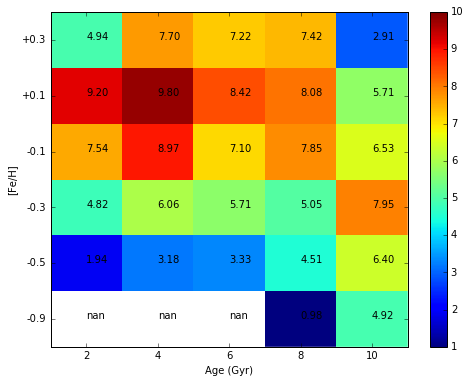

In [303]:
#star ratio on hercules stream

##########
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
im = ax.imshow((Nhermap/Nmap*mask_map).T,vmin=0,vmax=0.4,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
for i in xrange(6):
    for j in xrange(5):
        ax.text(j*2+1,i*2+1,'%(a).2f' % {'a':Nhermap[j,i]/Nmap[j,i]*mask_map[j,i]})
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Her_Ratio_AM.png',bbox_inches='tight')

##########
fig = plt.figure(figsize=[8,6])
ax = fig.add_subplot(111)
SNRmap = (Nhermap/Nmap)/np.sqrt(Nhermap/Nmap**2+Nhermap**2/Nmap**4*Nmap)
im = ax.imshow((SNRmap*mask_map).T,vmin=1,vmax=10.,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
for i in xrange(6):
    for j in xrange(5):
        ax.text(j*2+1,i*2+1,'%(a).2f' % {'a':SNRmap[j,i]*mask_map[j,i]})
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Her_Ratio_err_AM.png',bbox_inches='tight')



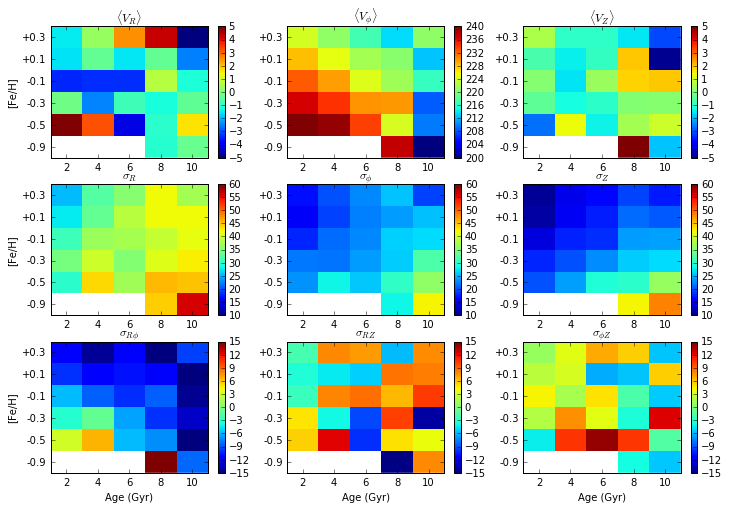

In [291]:
#############
vm=[[-5,5],[200,240],[-5,5],[10,60],[10,60],[10,60],[-15,15],[-15,15],[-15,15]]
fig = plt.figure(figsize=[12,8])
for i in xrange(9):
    ax = fig.add_subplot(3,3,i+1)
    im = ax.imshow(sig[i].T*mask_map.T,vmin=vm[i][0],vmax=vm[i][1],\
                   extent=[0,10,12,0],aspect='auto',interpolation='none')
    plt.colorbar(im)
    plt.title(tlabs[i])
    ax.set_xlim([0,10])
    ax.set_ylim([0,12])
    plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
    plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))

    if i>=6:
        plt.xlabel('Age (Gyr)')
    if i==0 or i==3 or i==6:
        plt.ylabel('[Fe/H]')
fig.show()
fig.savefig('velellip_AM.png')


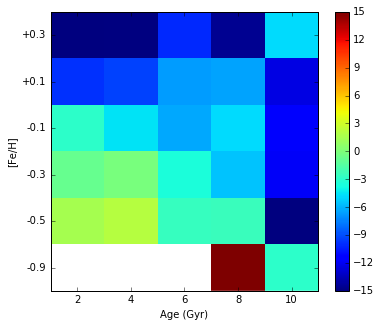

In [292]:
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(lv.T*mask_map.T,vmin=-15,vmax=15,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('vertex_deviation_AM.png')


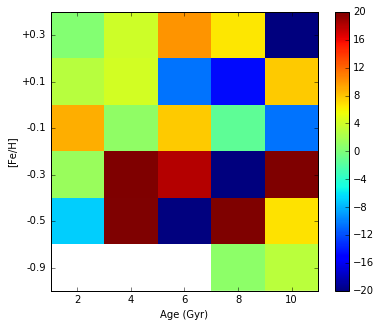

In [293]:
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(Alpha_PHIZ.T*mask_map.T,vmin=-20,vmax=20,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Alpha_PHIZ_AM.png')


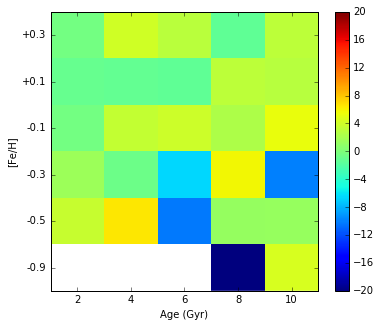

In [294]:
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow(Alpha_RZ.T*mask_map.T,vmin=-20,vmax=20,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('Alpha_RZ_AM.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


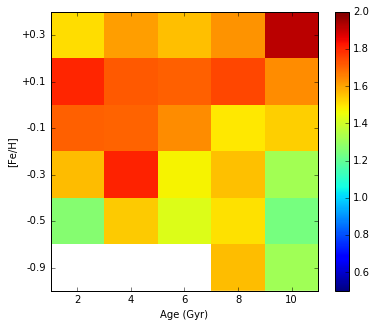

In [299]:
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow((sig[3]/sig[4]*mask_map).T,vmin=0.5,vmax=2,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('sR_SPHI_ratio_AM.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


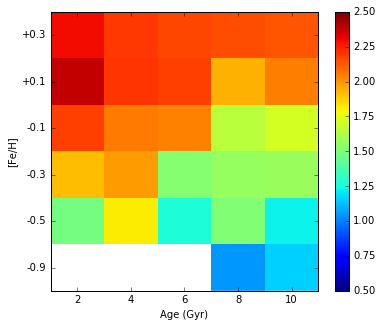

In [297]:
##########
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(111)
im = ax.imshow((sig[3]/sig[5]*mask_map).T,vmin=0.5,vmax=2.5,\
               extent=[0,10,12,0],aspect='auto',interpolation='none')
plt.colorbar(im)
ax.set_xlim([0,10])
ax.set_ylim([0,12])
plt.xticks([1,3,5,7,9],('2','4','6','8','10'))
plt.yticks([1,3,5,7,9,11],('-0.9','-0.5','-0.3','-0.1','+0.1','+0.3'))
plt.xlabel('Age (Gyr)')
plt.ylabel('[Fe/H]')

fig.show()
fig.savefig('sR_SZ_ratio_AM.png')

/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in less
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in greater
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in greater_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in less_equal
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:151: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:152: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:153: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:154

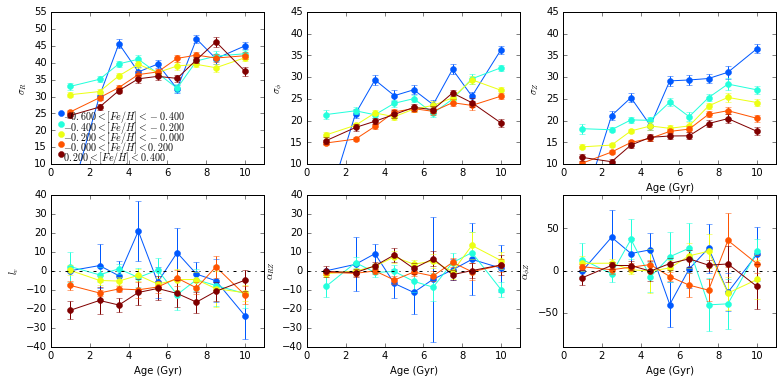

In [345]:
#only look at sigma
def colorPattern(n,type='jet'):
    '''
    Set different color map pattern
    
    Parameters: type='jet','gray','invgray'
    '''
    x=np.linspace(0,63,n)
    c=np.ndarray([len(x),3])
    if type=='jet':
        c[(x<=23),0] = 0.
        c[(x<=7)+(x>56),1] = 0.
        c[(x>39),2] = 0.
        
        c[(x>23) * (x<=39),0] = (x[(x>23) * (x<=39)]-23.)/(39.-23.)
        c[(x>7)*(x<=23),1] = (x[(x>7) * (x<=23)]-7.)/(23.-7.)
        c[(x<=7.),2] = (x[(x<=7.)]+7.)/(7.+7.)
        
        c[(x>39) * (x<=56),0] = 1.
        c[(x>23) * (x<=39),1] = 1.
        c[(x>7) * (x<=23),2] = 1.
        
        c[(x>56),0] = (70.-x[(x>56)])/(70.-56.)
        c[(x>39)*(x<=56),1] = (56.-x[(x>39) * (x<=56)])/(56.-39.)
        c[(x>23)*(x<=39),2] = (39.-x[(x>23) * (x<=39)])/(39.-23.)                
        
    else:
        if type=='gray':
            c[:,0] = x/63.
            c[:,1] = x/63.
            c[:,2] = x/63.
        else:#invgray
            c[:,0] = 1-x/63.
            c[:,1] = 1-x/63.
            c[:,2] = 1-x/63.
    return c
#Agegrid = np.array([np.log10(1e8),np.log10(2e9),np.log10(3e9),\
#                    np.log10(4e9),np.log10(5e9),np.log10(6e9),np.log10(7e9),\
#                   np.log10(8e9),np.log10(9e9),np.log10(15e9)])
Agegrid = np.array([0.1,2,3,4,5,6,7,8,9,15])
Agecenter =np.array([1,2.5,3.5,4.5,5.5,6.5,7.5,8.5,10])
ind0 = ind_SGB * (velerr[:,0]<225) * (velerr[:,3]<225) * (velerr[:,5]<225) *\
    (np.abs(VR)<150) * (np.abs(VPHI-238)<300) * (np.abs(VZ)<150) * (VPHI>100)
meanVR = np.zeros([len(Agecenter),len(fehcenter)])
meanVPHI = np.zeros([len(Agecenter),len(fehcenter)])
meanVZ = np.zeros([len(Agecenter),len(fehcenter)])
sig_RR = np.zeros([len(Agecenter),len(fehcenter)])
sig_RPHI = np.zeros([len(Agecenter),len(fehcenter)])
sig_RZ = np.zeros([len(Agecenter),len(fehcenter)])
sig_PHIPHI = np.zeros([len(Agecenter),len(fehcenter)])
sig_PHIZ = np.zeros([len(Agecenter),len(fehcenter)])
sig_ZZ = np.zeros([len(Agecenter),len(fehcenter)])
lv = np.zeros([len(Agecenter),len(fehcenter)])
Alpha_RZ = np.zeros([len(Agecenter),len(fehcenter)])
Alpha_PHIZ = np.zeros([len(Agecenter),len(fehcenter)])

meanVRerr = np.zeros([len(Agecenter),len(fehcenter)])
meanVPHIerr = np.zeros([len(Agecenter),len(fehcenter)])
meanVZerr = np.zeros([len(Agecenter),len(fehcenter)])
sig_RRerr = np.zeros([len(Agecenter),len(fehcenter)])
sig_RPHIerr = np.zeros([len(Agecenter),len(fehcenter)])
sig_RZerr = np.zeros([len(Agecenter),len(fehcenter)])
sig_PHIPHIerr = np.zeros([len(Agecenter),len(fehcenter)])
sig_PHIZerr = np.zeros([len(Agecenter),len(fehcenter)])
sig_ZZerr = np.zeros([len(Agecenter),len(fehcenter)])
lverr = np.zeros([len(Agecenter),len(fehcenter)])
Alpha_RZ_err = np.zeros([len(Agecenter),len(fehcenter)])
Alpha_PHIZ_err = np.zeros([len(Agecenter),len(fehcenter)])

Nmap = np.zeros([len(Agecenter),len(fehcenter)])
mask_map = np.zeros([len(Agecenter),len(fehcenter)])
for i in xrange(len(Agecenter)):
    for j in xrange(len(fehcenter)):
        ind = ind0 * (age>=Agegrid[i]) * (age<=Agegrid[i+1]) *\
            (tgas.feh>=fehgrid[j]) * (tgas.feh<=fehgrid[j+1])
        Nmap[i,j] = np.sum(ind)
        #print np.sum(ind)
        if np.sum(ind)>10:
            mask_map[i,j] = 1
            meanVR[i,j] = np.mean(VR[ind])
            meanVPHI[i,j] = np.mean(VPHI[ind])
            meanVZ[i,j] = np.mean(VZ[ind])
            sig_RR[i,j] = np.sum((VR[ind]-meanVR[i,j])**2)/np.sum(ind)-np.mean(velerr[ind,0])
            sig_RPHI[i,j] = np.sum((VR[ind]-meanVR[i,j])*(VPHI[ind]-meanVPHI[i,j]))/np.sum(ind)-np.mean(velerr[ind,1])
            sig_RZ[i,j] = np.sum((VR[ind]-meanVR[i,j])*(VZ[ind]-meanVZ[i,j]))/np.sum(ind)-np.mean(velerr[ind,2])
            sig_PHIPHI[i,j] = np.sum((VPHI[ind]-meanVPHI[i,j])**2)/np.sum(ind)-\
                np.mean(velerr[ind,3])
            sig_PHIZ[i,j] = np.sum((VPHI[ind]-meanVPHI[i,j])*(VZ[ind]-meanVZ[i,j]))/np.sum(ind)-np.mean(velerr[ind,4])
            sig_ZZ[i,j] = np.sum((VZ[ind]-meanVZ[i,j])**2)/np.sum(ind)-np.mean(velerr[ind,5])
            lv[i,j] = alpha(VR[ind],VPHI[ind])
            Alpha_RZ[i,j] = alpha(VR[ind],VZ[ind])
            Alpha_PHIZ[i,j] = alpha(VPHI[ind],VZ[ind])
            ###############
            ci = bootstrap(np.mean, VR[ind], 100, alpha=0.15)
            meanVRerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.mean, VPHI[ind], 100, alpha=0.15)
            meanVPHIerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.mean, VZ[ind], 100, alpha=0.15)
            meanVZerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.var,VR[ind],100,alpha=0.15)
            sig_RRerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.var,VPHI[ind],100,alpha=0.15)
            sig_PHIPHIerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap(np.var,VZ[ind],100,alpha=0.15)
            sig_ZZerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(sigmaxy,VR[ind],VPHI[ind],100,alpha=0.15)
            sig_RPHIerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(sigmaxy,VR[ind],VZ[ind],100,alpha=0.15)
            sig_RZerr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(sigmaxy,VPHI[ind],VZ[ind],100,alpha=0.15)
            sig_PHIZerr[i,j] = (ci[1]-ci[0])/2.0
                                      
            ci = bootstrap2(alpha,VR[ind],VPHI[ind],100,alpha=0.15)
            lverr[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(alpha,VR[ind],VZ[ind],100,alpha=0.15)
            Alpha_RZ_err[i,j] = (ci[1]-ci[0])/2.0
            ci = bootstrap2(alpha,VPHI[ind],VZ[ind],100,alpha=0.15)
            Alpha_PHIZ_err[i,j] = (ci[1]-ci[0])/2.0
        else:
            mask_map[i,j]=np.NAN    

#lv = 0.5*np.arctan(2*sig_RPHI/(sig_RR-sig_PHIPHI))*180.0/np.pi
#vv=sig_RR-sig_PHIPHI
#u = 2*sig_RPHI/(vv)
#lv = 0.5*np.arctan(u)*180.0/np.pi
#lverr = np.sqrt((0.5/(1+u**2))**2*\
#        (4*sig_RPHIerr/vv**2+\
#         4*sig_RRerr*sig_RPHI**2/vv**4+\
#         4*sig_PHIPHIerr*sig_RPHI**2/vv**4))

#vv=sig_PHIPHI-sig_ZZ
#u = 2*sig_PHIZ/(vv)
#Alpha_PHIZ = 0.5*np.arctan(u)*180.0/np.pi
#Alpha_PHIZ_err = np.sqrt((0.5/(1+u**2))**2*\
#        (4*sig_PHIZerr/vv**2+\
#         4*sig_PHIPHIerr*sig_PHIZ**2/vv**4+\
#         4*sig_ZZerr*sig_PHIZ**2/vv**4))

#vv=sig_RR-sig_ZZ
#u = 2*sig_RZ/(vv)
#Alpha_RZ = 0.5*np.arctan(u)*180.0/np.pi
#Alpha_RZ_err = np.sqrt((0.5/(1+u**2))**2*\
#        (4*sig_RZerr/vv**2+\
#         4*sig_RRerr*sig_RZ**2/vv**4+\
#         4*sig_ZZerr*sig_RZ**2/vv**4))

sig_RR = np.sqrt(sig_RR)
sig_RPHI = np.sign(sig_RPHI)*np.sqrt(np.abs(sig_RPHI))
sig_RZ = np.sign(sig_RZ)*np.sqrt(np.abs(sig_RZ))
sig_PHIPHI = np.sqrt(sig_PHIPHI)
sig_PHIZ = np.sign(sig_PHIZ)*np.sqrt(np.abs(sig_PHIZ))
sig_ZZ = np.sqrt(sig_ZZ)

sRRerr=np.sqrt(sig_RRerr/(4*np.abs(sig_RR)))
sRPHIerr=np.sqrt(sig_RPHIerr/(4*np.abs(sig_RPHI)))
sRZerr=np.sqrt(sig_RZerr/(4*np.abs(sig_RZ)))
sPHIPHIerr=np.sqrt(sig_PHIPHIerr/(4*np.abs(sig_PHIPHI)))
sPHIZerr=np.sqrt(sig_PHIZerr/(4*np.abs(sig_PHIZ)))
sZZerr=np.sqrt(sig_ZZerr/(4*np.abs(sig_ZZ)))


tlabs = [r'$\langle V_R\rangle$',r'$\langle V_\phi\rangle$',r'$\langle V_Z\rangle$',\
         r'$\sigma_R$',r'$\sigma_\phi$',r'$\sigma_Z$',\
         r'$\sigma_{R\phi}$',r'$\sigma_{RZ}$',r'$\sigma_{\phi Z}$']
sig = [meanVR,meanVPHI,meanVZ,sig_RR,sig_PHIPHI,sig_ZZ,sig_RPHI,sig_RZ,sig_PHIZ]    
cols=colorPattern(6)
#agecenter=[2,4,6,8,10]
fig = plt.figure(figsize=[13,6])
ax = fig.add_subplot(231)
for i in xrange(len(fehcenter)):
    #ind = sig_RR[:,i]>0.0
    if i>0:
        ax.errorbar(Agecenter[:],sig_RR[:,i],yerr=sRRerr[:,i],fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
        ax.plot(0.5,28-i*3,'o',color=cols[i,:],markeredgecolor=cols[i,:])
        ax.text(0.6,26-i*3,r'$%(a).3f<[Fe/H]<%(b).3f$' % {'a':fehgrid[i],'b':fehgrid[i+1]})
ax.set_xlim([0,11])
ax.set_ylim([10,55])
plt.ylabel(r'$\sigma_R$')
#################
ax = fig.add_subplot(232)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,sig_PHIPHI[:,i],yerr=sPHIPHIerr[:,i],\
                    fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.set_xlim([0,11])
ax.set_ylim([10,45])
plt.ylabel(r'$\sigma_\phi$')
##################
ax = fig.add_subplot(233)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,sig_ZZ[:,i],yerr=sZZerr[:,i],fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.set_xlim([0,11])
ax.set_ylim([10,45])
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$\sigma_Z$')
##################
ax = fig.add_subplot(234)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,lv[:,i]*180.0/np.pi,yerr=lverr[:,i]*180.0/np.pi,fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.plot([0,12],[0,0],'k-.')
ax.set_xlim([0,11])
ax.set_ylim([-40,40])
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$l_v$')
##################
ax = fig.add_subplot(235)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,Alpha_RZ[:,i]*180.0/np.pi,yerr=Alpha_RZ_err[:,i]*180.0/np.pi,fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.plot([0,12],[0,0],'k-.')
ax.set_xlim([0,11])
ax.set_ylim([-40,40])
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$\alpha_{RZ}$')
##################
ax = fig.add_subplot(236)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,Alpha_PHIZ[:,i]*180.0/np.pi,yerr=Alpha_PHIZ_err[:,i]*180.0/np.pi,fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
ax.plot([0,12],[0,0],'k-.')
ax.set_xlim([0,11])
ax.set_ylim([-90,90])
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$\alpha_{\phi Z}$')

fig.show()
fig.savefig('vdip_age.png')




/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/Users/chaoliu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in divide


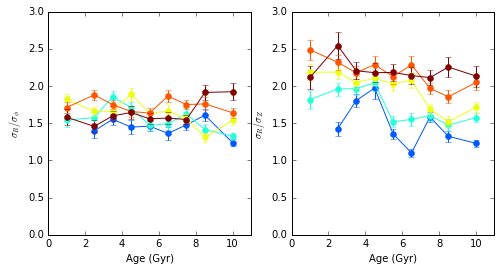

In [233]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,sig_RR[:,i]/sig_PHIPHI[:,i],\
                    yerr=np.sqrt(sRRerr[:,i]**2/sig_PHIPHI[:,i]**2+\
                    sPHIPHIerr[:,i]**2*sig_RR[:,i]**2/sig_PHIPHI[:,i]**4),\
                    fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.plot(0.5,28-i*3,'o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.text(0.6,26-i*3,r'$%(a).3f<[Fe/H]<%(b).3f$' % {'a':fehgrid[i],'b':fehgrid[i+1]})
ax.set_xlim([0,11])
ax.set_ylim([0,3])
plt.ylabel(r'$\sigma_R/\sigma_\phi$')
plt.xlabel('Age (Gyr)')
#################
ax = fig.add_subplot(122)
for i in xrange(len(fehcenter)):
    if i>0:
        ax.errorbar(Agecenter,sig_RR[:,i]/sig_ZZ[:,i],\
                    yerr=np.sqrt(sRRerr[:,i]**2/sig_ZZ[:,i]**2+\
                    sZZerr[:,i]**2*sig_RR[:,i]**2/sig_ZZ[:,i]**4),\
                    fmt='-o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.plot(0.5,28-i*3,'o',color=cols[i,:],markeredgecolor=cols[i,:])
        #ax.text(0.6,26-i*3,r'$%(a).3f<[Fe/H]<%(b).3f$' % {'a':fehgrid[i],'b':fehgrid[i+1]})
ax.set_xlim([0,11])
ax.set_ylim([0,3])
plt.ylabel(r'$\sigma_R/\sigma_Z$')
plt.xlabel('Age (Gyr)')
fig.show()

fig.savefig('sigmaratio_age.png')